## Context analysis using NLP
*Lab session for GEOG 595 Humanistic GIS Spring 2023*

Haoyu Yue, Urban Design and Planning, University of Washington

I use this opportunity to analysis the IPCC working group 2 report [Chapter 6: Cities, settlements and key infrastructure](https://www.ipcc.ch/report/ar6/wg2/downloads/report/IPCC_AR6_WGII_Chapter06.pdf). 

In [46]:
from os import listdir
from os.path import isfile, join
from fitz import open as fitzOpen
from tika import parser
import re
import string
from nltk.corpus import stopwords
import pickle
import nltk.data
from multiprocessing import cpu_count
from gensim.models import Word2Vec
from wordcloud import WordCloud, STOPWORDS
from nltk.probability import FreqDist
import numpy as np
from PIL import Image
import networkx as nx
from sklearn.manifold import TSNE  

### Preparation and text preprocessing

In [2]:
bookPath = "ipcc-cities"
delFrontPagePath = "delFrontPage"
txtPath = "ipcc-cities.txt"
pickledTxtPath = "ipcc-cities.bin"
modelPath = "ipcc-cities.w2v"
pdf = fitzOpen("ipcc-cities/ipcc-cities.pdf")

In [4]:
# extract the text
txt = ""
for page in range(pdf.page_count):
    txt += ' ' + pdf.get_page_text(page)

In [5]:
# processing 
txt = txt.lower()
txt = " ".join(txt.split())
txt = re.sub(r'[^\w\s]', '', txt)
txt = re.sub(r'\d+', '', txt)

In [6]:
def review_to_wordlist(review, remove_stopwords=False):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    # review_text = BeautifulSoup(review, 'html5lib').get_text()
    #
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]", " ", review)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return words


# Define a function to split a review into parsed sentences
def review_to_sentences(review, tokenizer, remove_stopwords=False):
    # Function to split a review into parsed sentences. Returns a
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            new_sentence = review_to_wordlist(raw_sentence, remove_stopwords)
            if new_sentence != [] and new_sentence != [u'none']:
                sentences.append(new_sentence)
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [7]:
if __name__ == "__main__":
    # download the punkt tokenizer for sentence splitting
    # nltk.download()
    # load the tokenizer
    import nltk
    nltk.download('stopwords')
    nltk.download('punkt')
    print('loading the tokenizer...')
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

    # read text file
    print("reading text file...")
    text = txt

    pickedTxt = review_to_sentences(text, tokenizer, remove_stopwords=True)
    data = [d for d in pickedTxt]
    # convert python objects into string representation for later use
    print("pickling the list...")
    with open(pickledTxtPath, "wb+") as fp:
        pickle.dump(data, fp)

    with open(pickledTxtPath, "rb") as fp:
        doc = pickle.load(fp)

    # train a model
    print("creating a model...")
    model = Word2Vec(doc, workers=cpu_count())
    model.save(modelPath)
    print("completed!")

[nltk_data] Downloading package stopwords to /Users/haoyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/haoyu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


loading the tokenizer...
reading text file...
pickling the list...
creating a model...
completed!


In [8]:
model.wv.most_similar(positive='hazard', topn=50)

[('arise', 0.8389880657196045),
 ('processes', 0.8266105055809021),
 ('report', 0.8261499404907227),
 ('within', 0.8260937929153442),
 ('includes', 0.8257888555526733),
 ('example', 0.8234758377075195),
 ('actions', 0.8233638405799866),
 ('scales', 0.8230255842208862),
 ('rural', 0.8230169415473938),
 ('exposed', 0.8226379156112671),
 ('sustainable', 0.8223169445991516),
 ('expected', 0.8221244812011719),
 ('risk', 0.8208826780319214),
 ('likely', 0.8205519914627075),
 ('reduction', 0.8204952478408813),
 ('risks', 0.8202450275421143),
 ('chapter', 0.8202343583106995),
 ('al', 0.8195940852165222),
 ('emerging', 0.8194370269775391),
 ('vulnerable', 0.8193085193634033),
 ('urbanisation', 0.8192094564437866),
 ('increased', 0.818592369556427),
 ('land', 0.8184010982513428),
 ('scenarios', 0.8183114528656006),
 ('confidence', 0.8183058500289917),
 ('specific', 0.8180724382400513),
 ('capacity', 0.8180534839630127),
 ('group', 0.8180301785469055),
 ('including', 0.817798376083374),
 ('disast

In [35]:
stopwords = set(STOPWORDS)
commonwords = {"time", "one", "began", "among", "another", "see", "part", "many", "day", "day", "way", "times",
               "still", "news", "three", "came", "became", "made", "wanted", "seemed", "made", "now", "society",
               "ing", "time", "first", "new", "called", "said", "come", "two", "city", "group", "state", "year",
               "case", "member", "even", "later", "month", "years", "much", "week", "county", "name", "example"
               "well", "members", "us", "say", "s", "et", "al", "j", "m", "a","b","l","d","c","h","e","p","f","g","i",
               "j","k","t","clim","sci"}
stopwords.update(commonwords)


In [15]:
# download corporas
import nltk
nltk.download('punkt')

# tokenize and calculate the word frequencies
tokens = nltk.tokenize.word_tokenize(txt)
fDist = FreqDist(tokens)
print(fDist.most_common(20))

[nltk_data] Downloading package punkt to /Users/haoyu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('and', 7363), ('of', 3434), ('the', 3366), ('in', 2888), ('to', 2318), ('al', 1646), ('et', 1644), ('a', 1594), ('climate', 1590), ('urban', 1535), ('for', 1371), ('adaptation', 1092), ('change', 1024), ('cities', 773), ('on', 681), ('infrastructure', 649), ('is', 617), ('as', 602), ('that', 585), ('are', 581)]


In [36]:
filtered_fDist = nltk.FreqDist(dict((word, freq) for word, freq in fDist.items() if word not in stopwords))

### Wordcloud

In [38]:
mask_array = np.array(Image.open("img/cloud.jpg"))
wc = WordCloud(font_path='verdana/Verdana-1.ttf', background_color="white", max_words=50, prefer_horizontal=1, mask=mask_array, scale=3, stopwords=stopwords, collocations=False)
wc.generate_from_frequencies(filtered_fDist)
# wc.generate(txt)
wc.to_file('ipcc-cities/ipcc-cities.jpg')
print("completed!")

completed!


Here is the result of wordcloud:
<div>
<img src="ipcc-cities/ipcc-cities.jpg" width="500"/>
</div>

### Social Network analysis

In [43]:
model = Word2Vec.load("ipcc-cities.w2v")
g = nx.DiGraph()

items = filtered_fDist.most_common(50)
for item in items:
    g.add_nodes_from(item[0])
    try:
        mswords = model.wv.most_similar(item[0], topn=25)
        for msword in mswords:
            g.add_nodes_from(msword[0])
            g.add_edge(item[0], msword[0], weight=msword[1])
            print("%s --> %s: %8.5f" % (item[0], msword[0], msword[1]))
    except KeyError as error:
        print(error)

climate --> risks:  0.99690
climate --> settlements:  0.99684
climate --> cities:  0.99658
climate --> urban:  0.99656
climate --> risk:  0.99619
climate --> areas:  0.99617
climate --> al:  0.99604
climate --> high:  0.99593
climate --> et:  0.99570
climate --> section:  0.99557
climate --> global:  0.99556
climate --> also:  0.99543
climate --> including:  0.99543
climate --> chapter:  0.99519
climate --> sustainable:  0.99512
climate --> infrastructure:  0.99509
climate --> example:  0.99483
climate --> key:  0.99468
climate --> vulnerability:  0.99463
climate --> confidence:  0.99462
climate --> people:  0.99451
climate --> urbanisation:  0.99444
climate --> heat:  0.99433
climate --> impacts:  0.99426
climate --> human:  0.99425
urban --> settlements:  0.99825
urban --> risks:  0.99819
urban --> al:  0.99804
urban --> also:  0.99803
urban --> cities:  0.99798
urban --> et:  0.99791
urban --> areas:  0.99789
urban --> high:  0.99778
urban --> section:  0.99724
urban --> including: 

In [45]:
nx.write_gexf(g, "ipcc-cities.gexf", encoding='utf-8', prettyprint=True, version='1.1draft')

Here is the result of network analysis:
<div>
<img src="ipcc-cities.png" width="800"/>
</div>

### Word Embeddings

In [50]:
def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.key_to_index:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model)

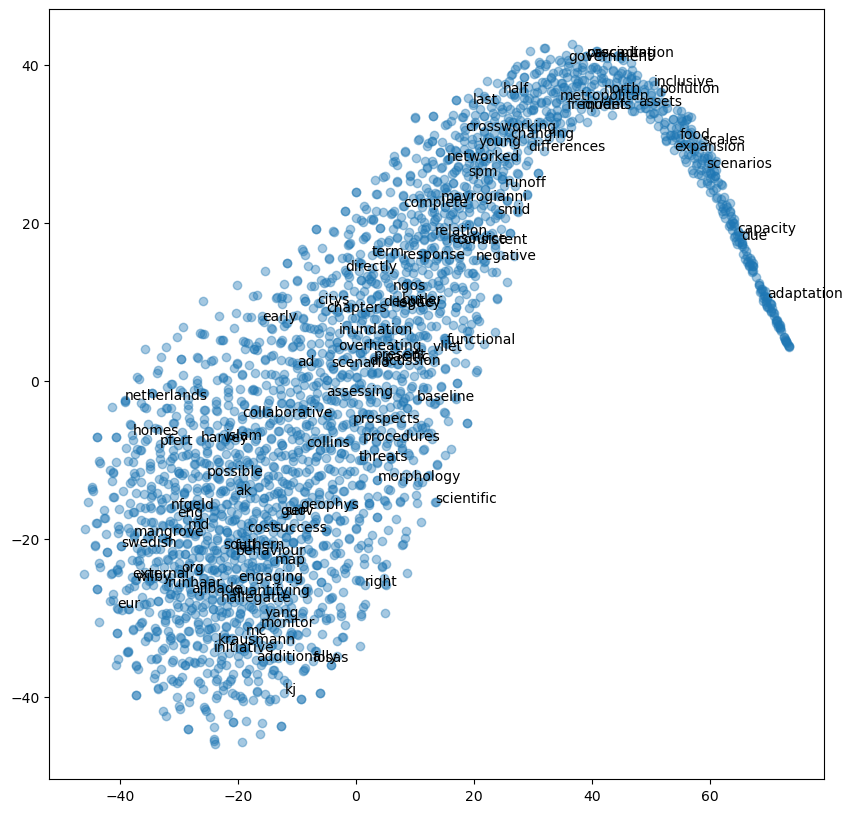

In [57]:
def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(10, 10))
    plt.scatter(x_vals, y_vals,alpha=0.4,marker="o")

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 100)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))
    plt.show()


plot_with_matplotlib(x_vals, y_vals, labels)